In [5]:
import random
import pandas as pd
from sklearn.cluster import DBSCAN
# from sklearn.cluster import SpectralClustering, AgglomerativeClustering, OPTICS, MeanShift # Not working

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Load list of API calls
API_LIST = "../api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #Add the label for NaN values.
API_FILE.close()

#Random Seed
seed = 1

def list_to_str(ls:list):
    '''Convert list to a stringified version (comma delimited).'''
    output = ""
    for l in ls:
        output += str(l) + ","
    return output[0:len(output)-1]

def load_df():
    '''Load the dataset file (CSV) as DataFrame'''
    print("Loading DF...")
    df = pd.read_csv("../oliveira.csv") # MAKE SURE THIS IS SET AS `oliveira.csv`
    #df = pd.read_csv("../oliveira_labelled.csv") # MAKE SURE THIS IS SET AS `oliveira.csv`
    df = df[df['malware'] == 1].copy()
    df = df.drop('malware', axis=1)
    print("")
    return df.reset_index().iloc[:,1:]

def get_x(df:pd.DataFrame):
    '''Get the feature columns of the DataFrame'''
    return df.iloc[:, 1:102-1]

#Inverse Label Encoding
def inverse_labeller(item):
    '''Low Level. Converts encoded API calls to string API calls'''
    global APIS
    return item.map(lambda x: APIS[int(x)])
def inverse_label(df:pd.DataFrame):
    '''High Level. Converts encoded API calls to string API calls'''
    df2 = df.copy(deep=True)
    print("Inverse Labelling...")
    df2.iloc[:, 1:101] = df2.iloc[:, 1:101].apply(inverse_labeller, axis=1, result_type='reduce')
    print("")
    return df2

def inject_patterns(inner_df:pd.DataFrame, inverse_labelled_df:pd.DataFrame):
    '''Injects the API call patterns of each sample as its last column'''
    patterns = []
    print("Injecting API patterns...")
    for row in range(inner_df.shape[0]):
        patterns.append(list_to_str(inverse_labelled_df.iloc[row,1:101].transpose().to_list()))
    inner_df['pattern'] = patterns
    print("")
    inverse_label(inner_df).to_csv(f"Clustering/Malicious/API_Patterns.csv", index=False)
    return inner_df

def common_api_cluster(inner_df:pd.DataFrame, name:str):
    '''Determine the most common API call patterns for each cluster'''
    global df
    inner_df = df
    clusters = inner_df['cluster'].unique()
    clusters.sort()
    commonAPI = []
    print("Searching for Common API Patterns per Cluster...")
    print(clusters)
    for cluster in clusters:
        raw_commonC = inner_df[inner_df['cluster']==cluster]['pattern']#.value_counts()
        commonC = raw_commonC.value_counts().to_frame(name='counts').reset_index()
        commonAPI.append([cluster, commonC['counts'].iloc[0], round(commonC['counts'].iloc[0]/raw_commonC.shape[0],4), commonC['pattern'].iloc[0]])
    commonAPI = pd.DataFrame(commonAPI, columns=['cluster', 'count', 'match_ratio', 'pattern'])
    commonAPI.to_csv(f"Clustering/Malicious/Manual_{name}_Common_API_Cluster.csv", index=False)
    print("")
    print("Average Match Ratio:", commonAPI['match_ratio'].mean())
    return commonAPI

def get_samplehash_common(inner_df:pd.DataFrame, common_counts:pd.DataFrame, name:str, samplesize:int):
    '''Get sample hashes from each cluster that matches the common API call pattern of the cluster.'''
    hashes = []
    # global seed
    # random.seed(seed)
    # matching_samples = 0
    # print(f"Random (Seed @ {seed}) Sampling Hashes subset of  Most Common API Patterns...")
    # for pattern in range(common_counts.shape[0]):
    #     sub_df = inner_df[inner_df['pattern']==common_counts.iloc[pattern,3]]
    #     subsamples = len(sub_df['hash'].to_list())
    #     matching_samples += subsamples
    #     if subsamples < samplesize:
    #         subsamples = random.sample(sub_df['hash'].to_list(), len(sub_df['hash'].to_list()))
    #     else:
    #         subsamples = random.sample(sub_df['hash'].to_list(), samplesize)
    #     for subsample in subsamples:
    #         hashes.append([common_counts.iloc[pattern,:]['cluster'], subsample, '_', '_', '_', common_counts.iloc[pattern,:]['pattern']])
    for i in range(inner_df.shape[0]):
        hashes.append([inner_df.iloc[i,:]['cluster'], inner_df.iloc[i,:]['hash'], '_', '_', '_', inner_df.iloc[i,:]['pattern']])
    hashes = pd.DataFrame(hashes, columns=['cluster', 'hash', 'Type 1', 'Type 2', 'Type 3', 'pattern'])
    hashes.to_csv(f"Clustering/Malicious/Manual_{name}_SampleHash_Common.csv", index=False)
    # print(f"Commonality Ratio: {(matching_samples/inner_df.shape[0])}")
    print("")
    return hashes

In [7]:
df = load_df()

# For oliveira with labels
# df = df[df['type'] != '_']

df

Loading DF...



,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,117,71,297,135,171,215,35,208,56,71
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,60,81,240,117,71,297,135,171,215,35
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,123,65,112,123,65,112,123,65,113,112
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,215,208,302,208,302,187,208,302,228,302
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,40,209,260,40,209,260,141,260,141,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42792,e3d6d58faa040f0f9742c9d0eaf58be4,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,141
42793,9b917bab7f32188ae40c744f2be9aaf8,82,240,117,240,117,240,117,240,117,...,82,159,224,82,159,224,82,159,224,82
42794,35a18ee05f75f04912018d9f462cb990,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,141,260
42795,654139d715abcf7ecdddbef5a84f224b,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,260,141


In [8]:
df = inject_patterns(df.copy(), inverse_label(df.copy()))
reserve_df = df.copy()
display(df.shape)

Inverse Labelling...

Injecting API patterns...

Inverse Labelling...



(42797, 102)

In [9]:
dbscan = DBSCAN(algorithm='auto', n_jobs=-1, min_samples=1)

X = get_x(df)
dbscan.fit(X)

DBSCAN(min_samples=1, n_jobs=-1)

cluster
0      3308
9      1116
105    1094
24     1059
155     863
39      802
19      738
50      703
40      698
21      576
58      539
8       486
27      485
97      434
23      411
113     396
295     367
63      349
13      344
208     306
Name: count, dtype: int64

<Axes: title={'center': 'Top 20 Clusters by Highest Sample Quantity'}, ylabel='cluster'>

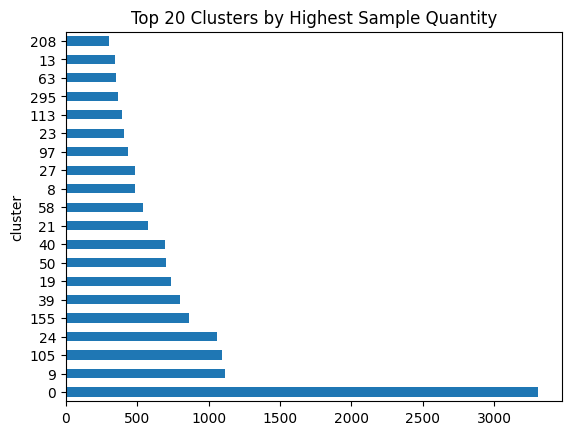

In [10]:
# TOP 10 CLUSTERS BY SAMPLE QUANTITY
df['cluster'] = dbscan.labels_
display(df['cluster'].value_counts()[0:20])
display(df['cluster'].value_counts()[0:20].plot(kind='barh', title='Top 20 Clusters by Highest Sample Quantity'))

In [11]:
display(df['cluster'].value_counts(ascending=True)[0:20])
#display(df['cluster'].value_counts(ascending=True)[0:20].plot(kind='barh',title='Top 20 Clusters by Lowest Sample Quantity'))

cluster
6298    1
8364    1
8365    1
8367    1
8369    1
8370    1
8371    1
8372    1
8373    1
8374    1
8375    1
8376    1
8377    1
8378    1
8379    1
8380    1
8381    1
8383    1
8384    1
8385    1
Name: count, dtype: int64

In [12]:
df.to_csv(f"./Clustering/Malicious/Manual_DBSCAN_Clustering.csv", index=False)

In [13]:
df = inverse_label(df)
df.to_csv(f"./Clustering/Malicious/Manual_DBSCAN_Encoded_Clustering.csv", index=False)

Inverse Labelling...



In [14]:
commonAPI = common_api_cluster(df, "DBSCAN")
display(commonAPI)

commonHashes = get_samplehash_common(df, commonAPI, "DBSCAN", 99999)
display(commonHashes)

Searching for Common API Patterns per Cluster...
[    0     1     2 ... 12594 12595 12596]

Average Match Ratio: 1.0


,cluster,count,match_ratio,pattern
0,0,3308,1.0,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos..."
1,1,128,1.0,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
2,2,8,1.0,"SetUnhandledExceptionFilter,OleInitialize,LdrL..."
3,3,1,1.0,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
4,4,1,1.0,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
...,...,...,...,...
12592,12592,1,1.0,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
12593,12593,1,1.0,"GetSystemTimeAsFileTime,GetSystemInfo,NtOpenKe..."
12594,12594,1,1.0,"LdrGetDllHandle,IsDebuggerPresent,NtQuerySyste..."
12595,12595,1,1.0,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."


,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,071e8c3f8922e186e57548cd4c703a5d,_,_,_,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos..."
1,1,33f8e6d08a6aae939f25a8e0d63dd523,_,_,_,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
2,2,b68abd064e975e1c6d5f25e748663076,_,_,_,"SetUnhandledExceptionFilter,OleInitialize,LdrL..."
3,3,72049be7bd30ea61297ea624ae198067,_,_,_,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
4,4,c9b3700a77facf29172f32df6bc77f48,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
...,...,...,...,...,...,...
42792,19,e3d6d58faa040f0f9742c9d0eaf58be4,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
42793,12595,9b917bab7f32188ae40c744f2be9aaf8,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
42794,12596,35a18ee05f75f04912018d9f462cb990,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
42795,19,654139d715abcf7ecdddbef5a84f224b,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
